# Bayesian Optimisation of a LightGBM Model

In [ ]:
import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer


# Evaluation of the model
#from sklearn.model_selection import KFold


##Data

Data details: https://www.kaggle.com/datasets/uciml/caravan-insurance-challenge

Queremos hacer una clasificación en Número de pólizas de casas móviles

In [ ]:
link = 'https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/data/caravan-insurance-challenge.csv?raw=true'
data = pd.read_csv(link)
print(data.shape)
data.head()


(9822, 87)


,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,)) # Número de pólizas de casas móviles
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,)) # Número de pólizas de casas móviles

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


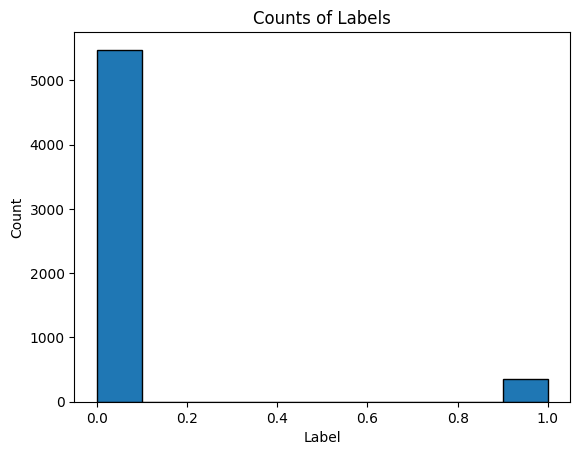

In [ ]:
plt.hist(labels, edgecolor = 'k');
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

In [ ]:
q_zero = len(labels[labels == 0])
q_one = len(labels[labels == 1])
scale_pos_weight = q_zero/q_one
scale_pos_weight

15.729885057471265

## Gradient Boosting Machine Default Model

See details: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [ ]:
# Model with default hyperparameters
model = lgb.LGBMClassifier(force_row_wise=True, verbose=-1)

In [ ]:
start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7089.
The baseline training time is 0.3262 seconds


El AUC varía en valor de 0 a 1. Un modelo cuyas predicciones son un 100% incorrectas tiene un AUC de 0.0; uno cuyas predicciones son un 100% correctas tiene un AUC de 1.0.

## Random Search


In [ ]:
help(lgb.LGBMClassifier())

Help on LGBMClassifier in module lightgbm.sklearn object:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable[[Optional[numpy.ndarray], numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], Callable[[Optional[numpy.ndarray], numpy.ndarray, Optional[numpy.ndarray], Optional[numpy.ndarray]], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.Random

In [ ]:
# Hyperparameter grid
param_fix = {'force_row_wise' : True, 'verbose' : -1}

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'class_weight': [None, 'balanced'],
    'scale_pos_weight' : list(np.linspace(0.0001, 30, 100)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample' : list(np.linspace(0.5, 1, 100)),
    }

LightGBM utiliza una técnica novedosa de muestreo de un lado basado en gradiente (GOSS)

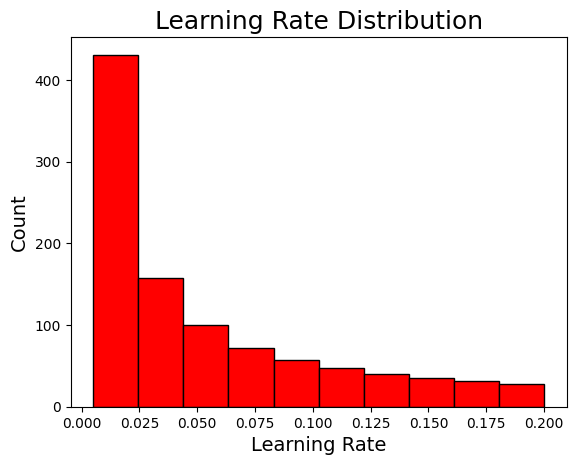

In [ ]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

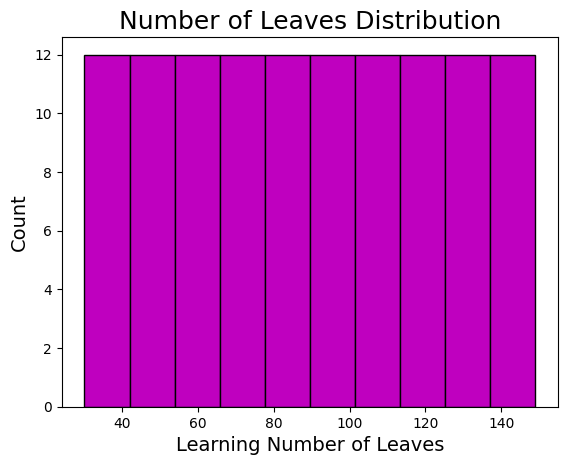

In [ ]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

## Sampling from Hyperparameter Domain


In [ ]:
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'dart',
 'num_leaves': 145,
 'learning_rate': 0.07629108329695573,
 'subsample_for_bin': 180000,
 'min_child_samples': 265,
 'class_weight': None,
 'scale_pos_weight': 6.969773737373737,
 'reg_alpha': 0.7755102040816326,
 'reg_lambda': 0.5918367346938775,
 'colsample_bytree': 0.7777777777777778,
 'subsample': 0.8737373737373737}

In [ ]:
def Merge(dict_1, dict_2):
	result = dict_1 | dict_2
	return result

params = Merge(params,param_fix)
params

{'boosting_type': 'dart',
 'num_leaves': 145,
 'learning_rate': 0.07629108329695573,
 'subsample_for_bin': 180000,
 'min_child_samples': 265,
 'class_weight': None,
 'scale_pos_weight': 6.969773737373737,
 'reg_alpha': 0.7755102040816326,
 'reg_lambda': 0.5918367346938775,
 'colsample_bytree': 0.7777777777777778,
 'subsample': 0.8737373737373737,
 'force_row_wise': True,
 'verbose': -1}

In [ ]:
# Model with random hyperparameters
model = lgb.LGBMClassifier(**params)

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7221.
The baseline training time is 0.3811 seconds


## Cross Validation with Early Stopping in LightGBM


See details: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html

In [ ]:
%%time

train_set = lgb.Dataset(features, label = labels)

# Perform cross validation with 10 folds
r = lgb.cv(params, train_set, num_boost_round = 100, nfold = 10, metrics = 'auc')

# Highest score
r_best = np.max(r['valid auc-mean'])

# Loss must be minimized
loss = 1 - r_best

# Standard deviation of best score
r_best_std = r['valid auc-stdv'][np.argmax(r['valid auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The loss was {}.'.format(loss))
print('The ideal number of iterations was {}.'.format(np.argmax(r['valid auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.76850 with std of 0.03979.
The loss was 0.2315029092008839.
The ideal number of iterations was 86.
CPU times: user 3.37 s, sys: 39.1 ms, total: 3.41 s
Wall time: 1.86 s


In [ ]:
random_estimators = int(np.argmax(r['valid auc-mean']) + 1)

# Model with random hyperparameters
best_random_model = lgb.LGBMClassifier(**params, n_estimators=random_estimators, n_jobs = -1,
                                       objective = 'binary', random_state = 50)

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7221.
The baseline training time is 0.2651 seconds


## Results Dataframe

In [ ]:
# Dataframe to hold cv results
MAX_EVALS = 200
N_FOLDS = 10
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))
random_results

,loss,params,iteration,estimators,time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN


## Objective Function

In [ ]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds, metrics = 'auc')
    end = timer()

    best_score = np.max(cv_results['valid auc-mean'])

    # Loss must be minimized
    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['valid auc-mean']) + 1)

    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

# Random Search Implementation


In [ ]:
#%%capture
#%%time
#random.seed(50)
train_set = lgb.Dataset(features, label = labels, free_raw_data = False)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    params = Merge(params,param_fix)

    if i%10 == 0:
      print('i = {} with {}'.format(i,params))

    results_list = random_objective(params, i)

    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

i = 0 with {'boosting_type': 'gbdt', 'num_leaves': 77, 'learning_rate': 0.017742983063581876, 'subsample_for_bin': 100000, 'min_child_samples': 155, 'class_weight': None, 'scale_pos_weight': 22.424267676767677, 'reg_alpha': 0.14285714285714285, 'reg_lambda': 0.8775510204081632, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.7373737373737375, 'force_row_wise': True, 'verbose': -1}
i = 10 with {'boosting_type': 'gbdt', 'num_leaves': 140, 'learning_rate': 0.11367617618284119, 'subsample_for_bin': 140000, 'min_child_samples': 345, 'class_weight': None, 'scale_pos_weight': 12.121271717171716, 'reg_alpha': 0.04081632653061224, 'reg_lambda': 0.2857142857142857, 'colsample_bytree': 0.6888888888888889, 'subsample': 0.9040404040404041, 'force_row_wise': True, 'verbose': -1}
i = 20 with {'boosting_type': 'gbdt', 'num_leaves': 131, 'learning_rate': 0.051580486530718374, 'subsample_for_bin': 40000, 'min_child_samples': 405, 'class_weight': 'balanced', 'scale_pos_weight': 25.15153131313131, 

In [ ]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results

,loss,params,iteration,estimators,time
0,0.230287,"{'boosting_type': 'gbdt', 'num_leaves': 130, '...",168,40,0.851861
1,0.232205,"{'boosting_type': 'gbdt', 'num_leaves': 133, '...",4,21,0.841154
2,0.23244,"{'boosting_type': 'dart', 'num_leaves': 149, '...",105,31,1.96486
3,0.23318,"{'boosting_type': 'gbdt', 'num_leaves': 120, '...",144,29,0.848717
4,0.233634,"{'boosting_type': 'dart', 'num_leaves': 114, '...",189,31,2.931335
...,...,...,...,...,...
195,0.277141,"{'boosting_type': 'dart', 'num_leaves': 49, 'l...",112,100,2.535359
196,0.277841,"{'boosting_type': 'gbdt', 'num_leaves': 125, '...",56,71,2.597272
197,0.278773,"{'boosting_type': 'gbdt', 'num_leaves': 79, 'l...",111,10,1.835748
198,0.2833,"{'boosting_type': 'gbdt', 'num_leaves': 144, '...",78,5,1.916286


## Random Search Performance


In [ ]:
random_results.loc[0, 'params']

{'boosting_type': 'gbdt',
 'num_leaves': 130,
 'learning_rate': 0.06112993899940833,
 'subsample_for_bin': 60000,
 'min_child_samples': 255,
 'class_weight': 'balanced',
 'scale_pos_weight': 25.15153131313131,
 'reg_alpha': 0.5306122448979591,
 'reg_lambda': 0.4081632653061224,
 'colsample_bytree': 0.6444444444444444,
 'subsample': 0.5909090909090909,
 'force_row_wise': True,
 'verbose': -1}

In [ ]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators,
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7130 on the test data.
This was achieved using 168 search iterations.


<Axes: >

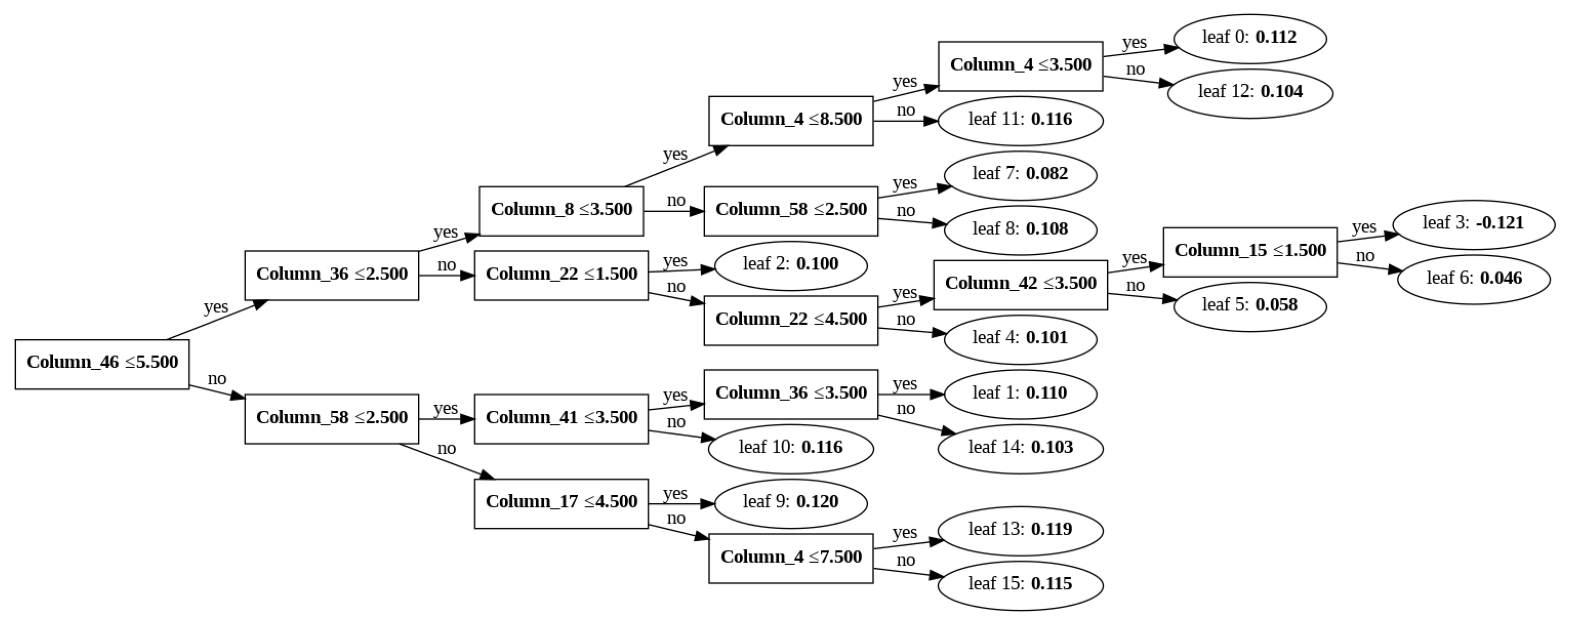

In [ ]:
lgb.plot_tree(best_random_model, figsize=(20,10))

# Bayesian Hyperparameter Optimization using Hyperopt

## Objective Function

In [ ]:
# Dataframe to hold cv results
results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'train_time'],
                       index = list(range(MAX_EVALS)))

results

,loss,params,iteration,estimators,train_time
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
195,NaN,NaN,NaN,NaN,NaN
196,NaN,NaN,NaN,NaN,NaN
197,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,NaN,NaN,NaN


In [ ]:
from hyperopt import STATUS_OK

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""

    # Keep track of evals
    global ITERATION

    ITERATION += 1

    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])

    start = timer()

    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds,
                       metrics = 'auc')

    run_time = timer() - start

    # Extract the best score
    best_score = np.max(cv_results['valid auc-mean'])

    # Loss must be minimized
    loss = 1 - best_score

    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['valid auc-mean']) + 1)

    # Write to a DataFrame results
    results.loc[ITERATION-1, :]=[loss, params, ITERATION, n_estimators, run_time]

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators,
            'train_time': run_time, 'status': STATUS_OK}

## Domain Space

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

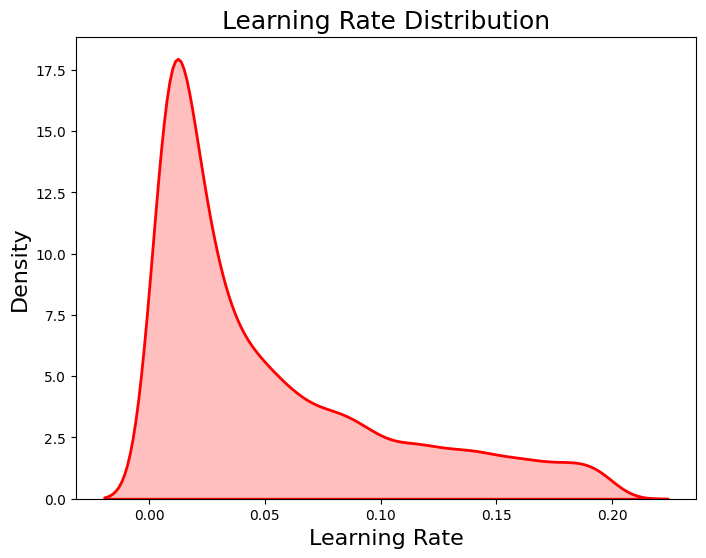

In [ ]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, fill=True);
plt.title('Learning Rate Distribution', size = 18);
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

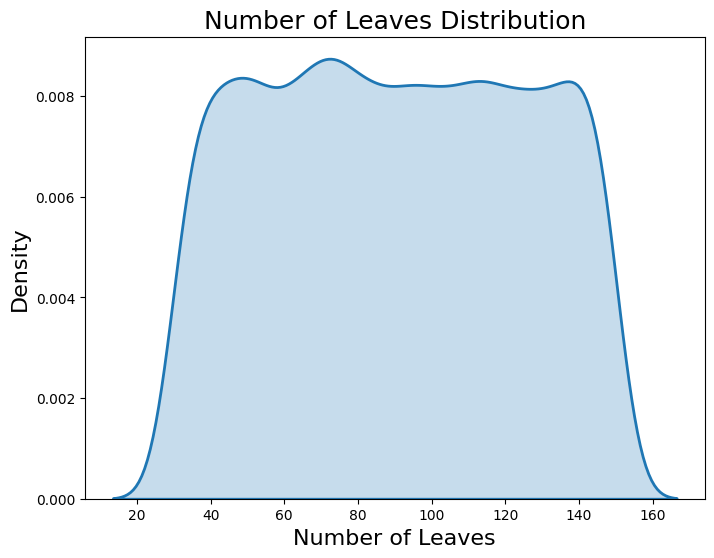

In [ ]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])

# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, fill=True);
plt.title('Number of Leaves Distribution', size = 18);
plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

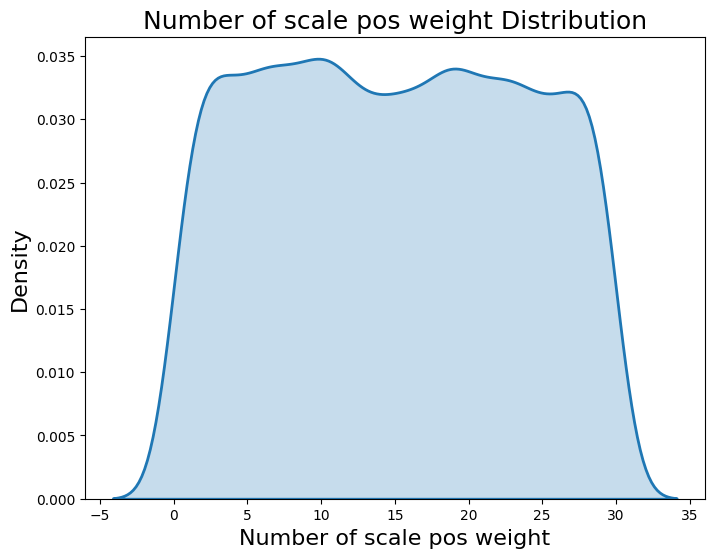

In [ ]:
# Discrete uniform distribution
scale_pos_weight = {'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 30)}
scale_pos_weight_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    scale_pos_weight_dist.append(sample(scale_pos_weight)['scale_pos_weight'])

# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(scale_pos_weight_dist, linewidth = 2, fill=True);
plt.title('Number of scale pos weight Distribution', size = 18);
plt.xlabel('Number of scale pos weight', size = 16); plt.ylabel('Density', size = 16);

## Complete Bayesian Domain

In [ ]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'scale_pos_weight' : hp.uniform('scale_pos_weight', 0, 30),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'subsample' : hp.uniform('subsample', 0.5, 1),
    }


In [ ]:
#Add the fix parameters
space = Merge(space, param_fix)
space

{'boosting_type': <hyperopt.pyll.base.Apply at 0x7c449908af50>,
 'num_leaves': <hyperopt.pyll.base.Apply at 0x7c449908b730>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x7c449900fe20>,
 'subsample_for_bin': <hyperopt.pyll.base.Apply at 0x7c449900f4f0>,
 'min_child_samples': <hyperopt.pyll.base.Apply at 0x7c449af0aaa0>,
 'class_weight': <hyperopt.pyll.base.Apply at 0x7c449af0ab60>,
 'scale_pos_weight': <hyperopt.pyll.base.Apply at 0x7c44990a4460>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7c44990a4580>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7c44990a46a0>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7c44990a5fc0>,
 'subsample': <hyperopt.pyll.base.Apply at 0x7c44990a60e0>,
 'force_row_wise': True,
 'verbose': -1}

## Example of Sampling from the Domain

In [ ]:
# Sample from the full space
x = sample(space)
x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7756480399505057,
 'force_row_wise': True,
 'learning_rate': 0.03461009078668204,
 'min_child_samples': 115.0,
 'num_leaves': 112.0,
 'reg_alpha': 0.5023506992577164,
 'reg_lambda': 0.4963600253861774,
 'scale_pos_weight': 26.50232780716159,
 'subsample': 0.8762427121949259,
 'subsample_for_bin': 140000.0,
 'verbose': -1}

## Optimization Algorithm

In [ ]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

## Results History

In [ ]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

## Bayesian Optimization

In [ ]:
from hyperopt import fmin

In [ ]:
%%time
#%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.default_rng(50))


100%|██████████| 200/200 [06:14<00:00,  1.87s/trial, best loss: 0.23058985201521331]
CPU times: user 11min 14s, sys: 6.43 s, total: 11min 20s
Wall time: 6min 14s


In [ ]:
bayes_trials.results

[{'loss': 0.24021788715886683,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.9388624212214933,
   'force_row_wise': True,
   'learning_rate': 0.01432681909505215,
   'min_child_samples': 445,
   'num_leaves': 66,
   'reg_alpha': 0.8988389508102242,
   'reg_lambda': 0.5125902292261353,
   'scale_pos_weight': 9.812173656221251,
   'subsample': 0.811135297575367,
   'subsample_for_bin': 180000,
   'verbose': -1},
  'iteration': 1,
  'estimators': 50,
  'train_time': 0.709942116999855,
  'status': 'ok'},
 {'loss': 0.24624498023098007,
  'params': {'boosting_type': 'gbdt',
   'class_weight': 'balanced',
   'colsample_bytree': 0.8856050179833065,
   'force_row_wise': True,
   'learning_rate': 0.013144618630963792,
   'min_child_samples': 135,
   'num_leaves': 64,
   'reg_alpha': 0.569766741085208,
   'reg_lambda': 0.8384626374035719,
   'scale_pos_weight': 12.129470258814788,
   'subsample': 0.6334598245354541,
   'subsample_for_bin': 220000,
 

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.23058985201521331,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.8283420622912022,
   'force_row_wise': True,
   'learning_rate': 0.09392944808592546,
   'min_child_samples': 245,
   'num_leaves': 68,
   'reg_alpha': 0.7129073597265414,
   'reg_lambda': 0.7456327737052448,
   'scale_pos_weight': 24.91317590309273,
   'subsample': 0.6441526732440431,
   'subsample_for_bin': 180000,
   'verbose': -1},
  'iteration': 67,
  'estimators': 83,
  'train_time': 1.7084585610000431,
  'status': 'ok'},
 {'loss': 0.23110173921848598,
  'params': {'boosting_type': 'dart',
   'class_weight': None,
   'colsample_bytree': 0.8092265388876311,
   'force_row_wise': True,
   'learning_rate': 0.10135664729534806,
   'min_child_samples': 255,
   'num_leaves': 116,
   'reg_alpha': 0.8372478647266041,
   'reg_lambda': 0.7053904968475649,
   'scale_pos_weight': 12.76064999291529,
   'subsample': 0.5213439899175978,
   'subsample_for_bin': 260000,
   'verbos

In [ ]:
# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.23059,"{'boosting_type': 'dart', 'class_weight': None...",67,83,1.708459
1,0.231102,"{'boosting_type': 'dart', 'class_weight': None...",111,73,2.843469
2,0.231257,"{'boosting_type': 'dart', 'class_weight': None...",146,99,2.737253
3,0.231421,"{'boosting_type': 'dart', 'class_weight': None...",145,79,1.643576
4,0.23159,"{'boosting_type': 'dart', 'class_weight': None...",30,89,2.845952


In [ ]:
results.loc[0,'params']

{'boosting_type': 'dart',
 'class_weight': None,
 'colsample_bytree': 0.8283420622912022,
 'force_row_wise': True,
 'learning_rate': 0.09392944808592546,
 'min_child_samples': 245,
 'num_leaves': 68,
 'reg_alpha': 0.7129073597265414,
 'reg_lambda': 0.7456327737052448,
 'scale_pos_weight': 24.91317590309273,
 'subsample': 0.6441526732440431,
 'subsample_for_bin': 180000,
 'verbose': -1}

## Evaluate Best Results

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = results.loc[0, 'params'].copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators,
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(boosting_type='dart', colsample_bytree=0.8283420622912022,
               force_row_wise=True, learning_rate=0.09392944808592546,
               min_child_samples=245, n_estimators=83, num_leaves=68,
               objective='binary', random_state=50,
               reg_alpha=0.7129073597265414, reg_lambda=0.7456327737052448,
               scale_pos_weight=24.91317590309273, subsample=0.6441526732440431,
               subsample_for_bin=180000, verbose=-1)

In [ ]:
# Evaluate on the testing data
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.71822 AUC ROC on the test set.
This was achieved after 67 search iterations


<Axes: >

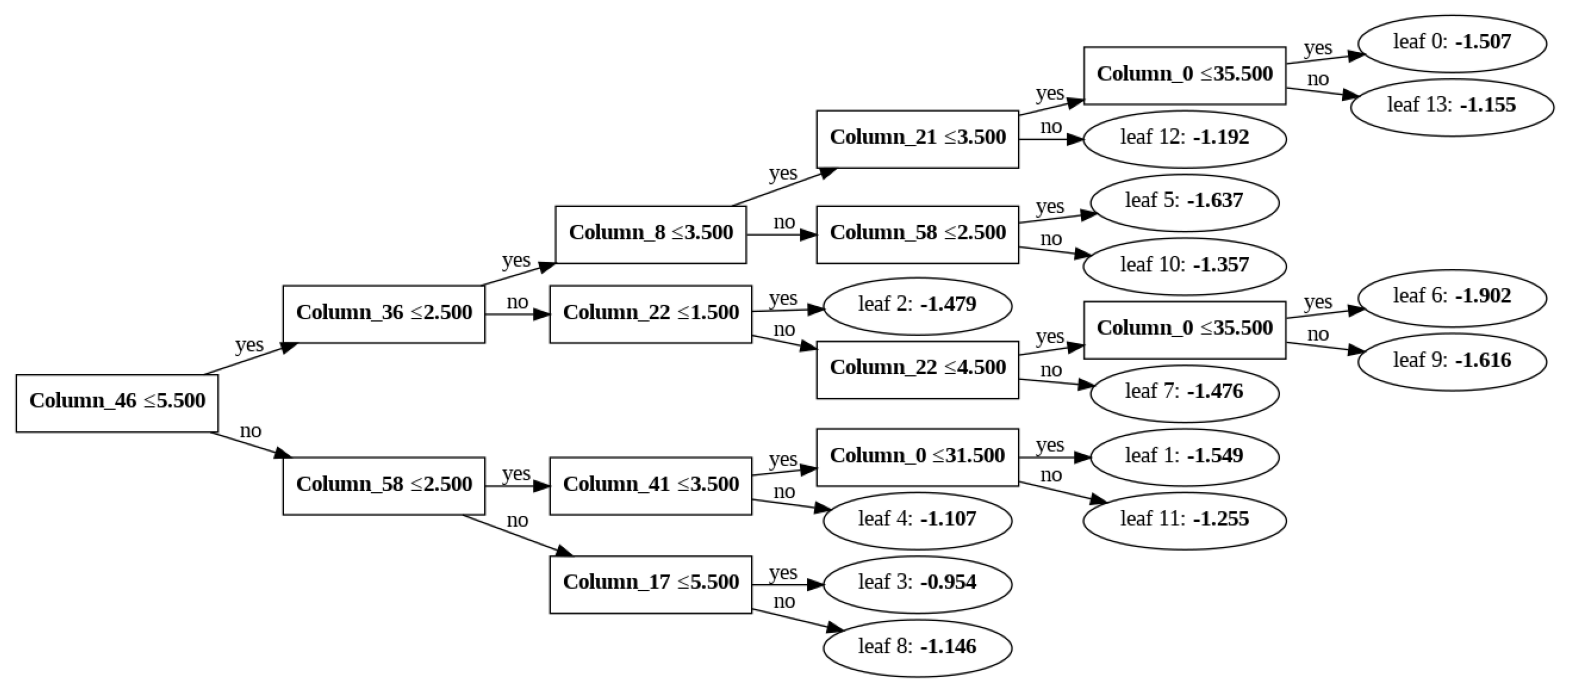

In [ ]:
lgb.plot_tree(best_bayes_model, figsize=(20,10))

# Comparison to Random Search

In [ ]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'

best_params = pd.DataFrame([best_random_params, best_bayes_params])
best_params

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,class_weight,scale_pos_weight,reg_alpha,reg_lambda,colsample_bytree,subsample,force_row_wise,verbose,method
0,gbdt,130,0.061130,60000,255,balanced,25.151531,0.530612,0.408163,0.644444,0.590909,True,-1,random search
1,dart,68,0.093929,180000,245,None,24.913176,0.712907,0.745633,0.828342,0.644153,True,-1,Bayesian optimization


In [ ]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())

random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,class_weight,scale_pos_weight,reg_alpha,reg_lambda,colsample_bytree,subsample,force_row_wise,verbose,loss,iteration
0,gbdt,130,0.06113,60000,255,balanced,25.151531,0.530612,0.408163,0.644444,0.590909,True,-1,0.230287,168
1,gbdt,133,0.115794,40000,255,balanced,0.606159,0.0,0.306122,0.822222,0.762626,True,-1,0.232205,4
2,dart,149,0.054518,100000,175,balanced,27.575766,0.326531,0.163265,0.644444,0.671717,True,-1,0.23244,105
3,gbdt,120,0.086178,180000,250,None,21.51518,0.530612,0.897959,0.688889,0.828283,True,-1,0.23318,144
4,dart,114,0.028675,20000,170,None,4.848569,0.938776,0.469388,0.644444,0.934343,True,-1,0.233634,189


In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(results.loc[0, 'params'].keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(params.values())

bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

,boosting_type,class_weight,colsample_bytree,force_row_wise,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,scale_pos_weight,subsample,subsample_for_bin,verbose,loss,iteration
0,dart,None,0.828342,True,0.093929,245,68,0.712907,0.745633,24.913176,0.644153,180000,-1,0.23059,67
1,dart,None,0.809227,True,0.101357,255,116,0.837248,0.70539,12.76065,0.521344,260000,-1,0.231102,111
2,dart,None,0.624534,True,0.045316,285,101,0.749059,0.371019,25.182993,0.573305,180000,-1,0.231257,146
3,dart,None,0.61553,True,0.045282,280,88,0.781939,0.35025,25.290633,0.572062,180000,-1,0.231421,145
4,dart,None,0.63288,True,0.069658,265,47,0.15603,0.707435,18.197837,0.594517,140000,-1,0.23159,30


Learning Rates

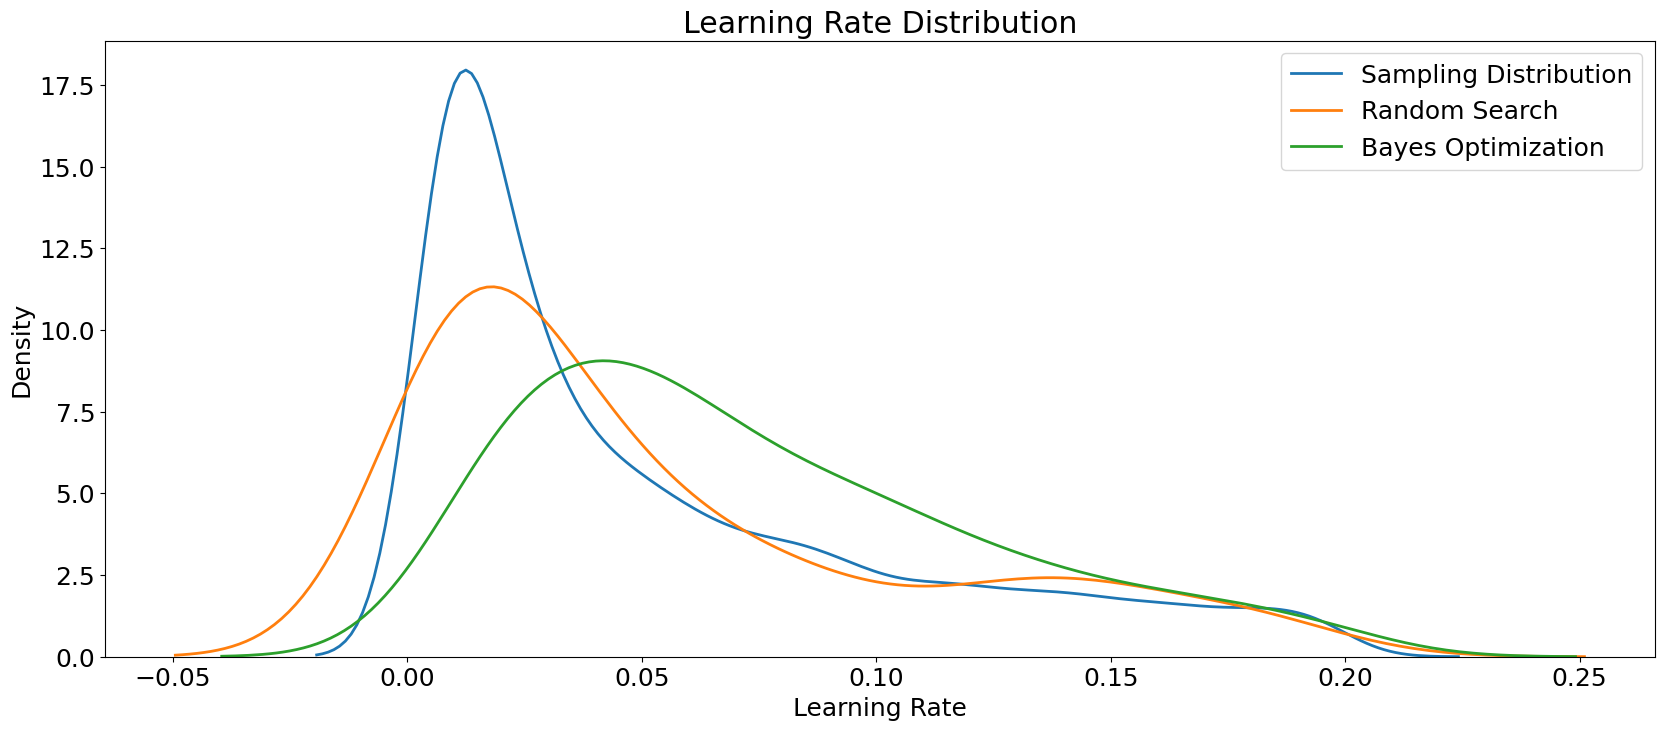

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

Class weight

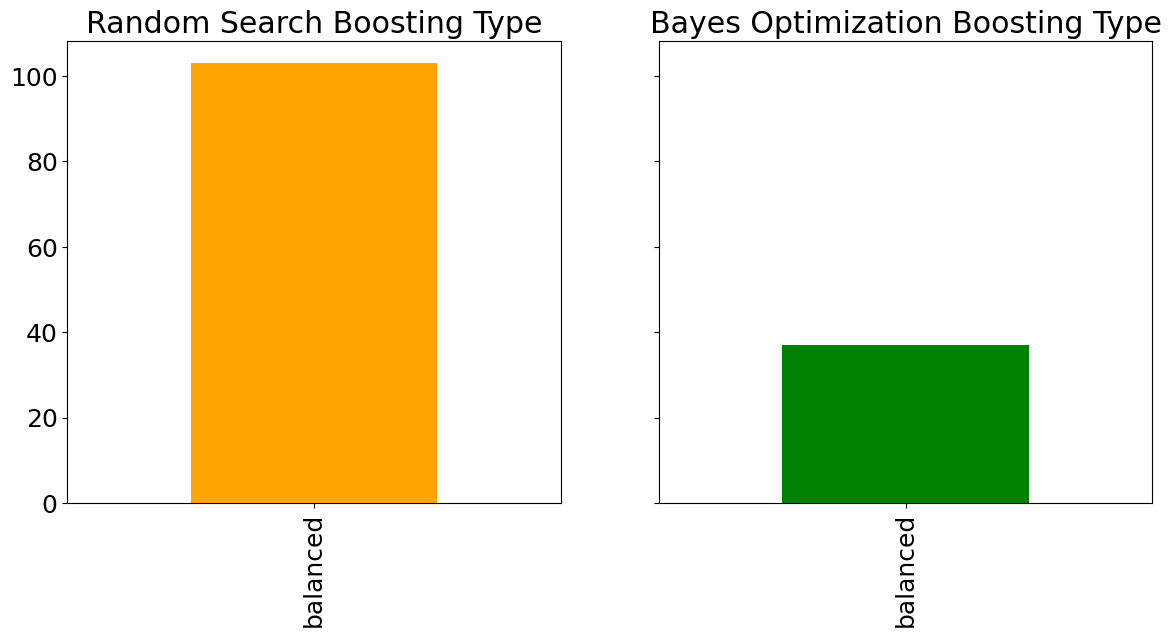

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['class_weight'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['class_weight'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

Is it unbalance?

Boosting Type

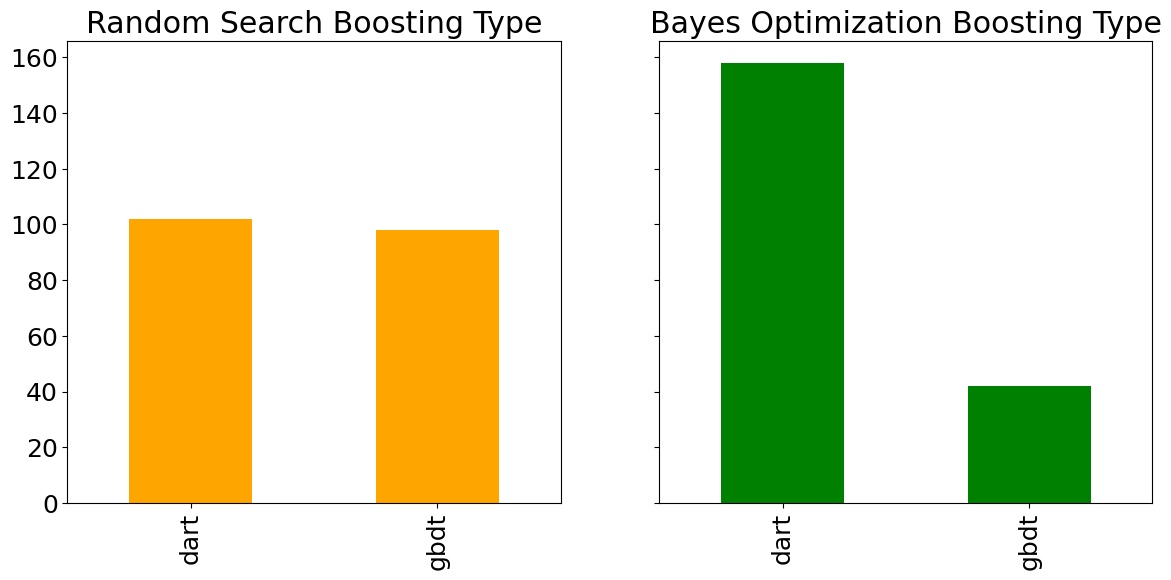

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

## Plots of All Numeric Hyperparameters

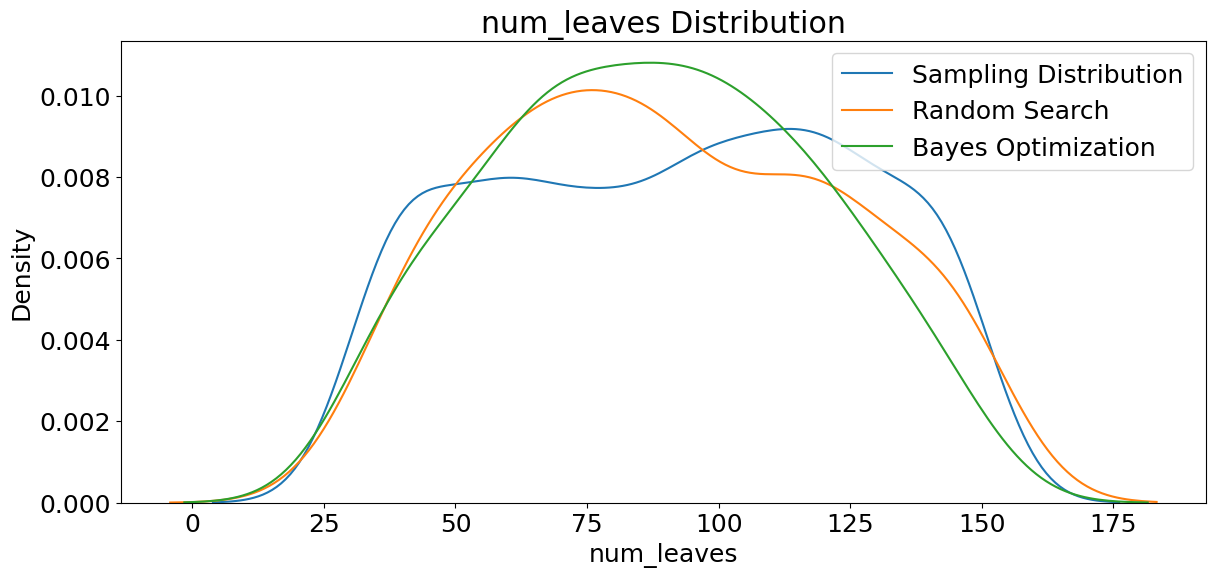

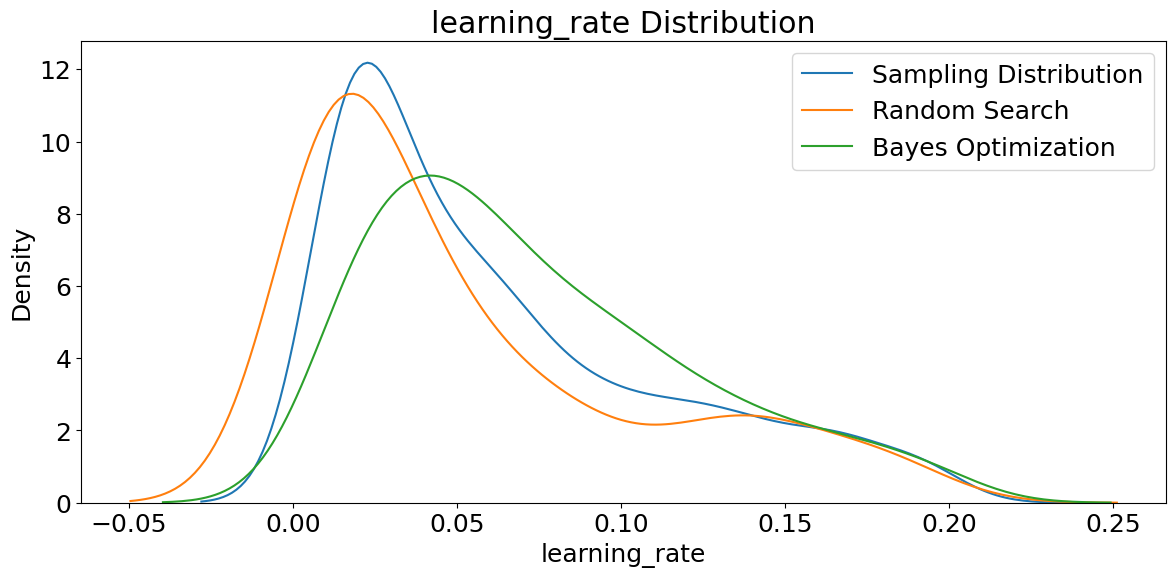

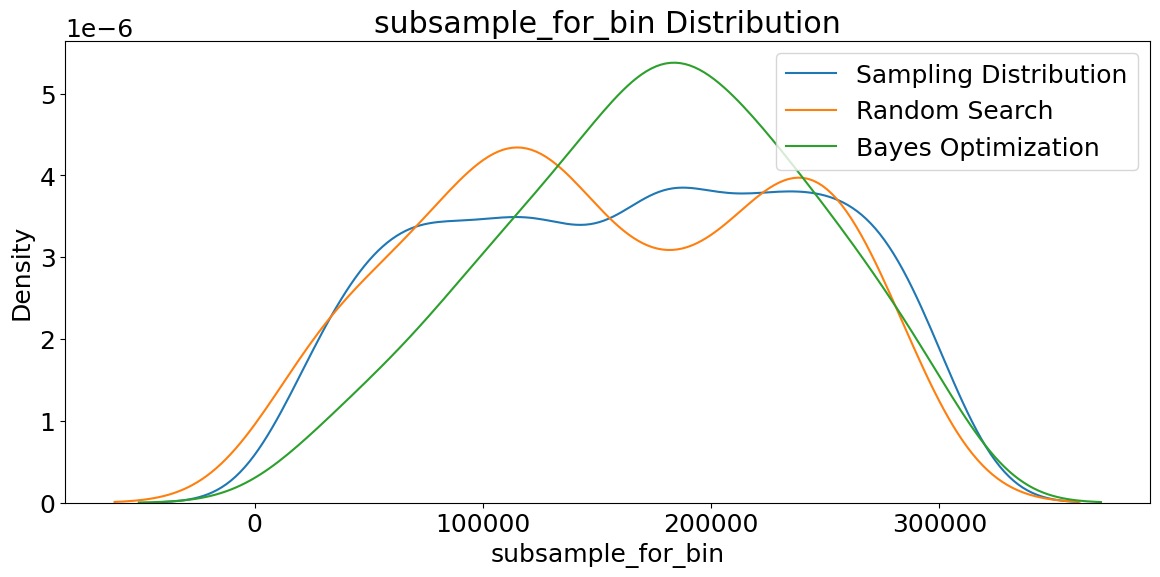

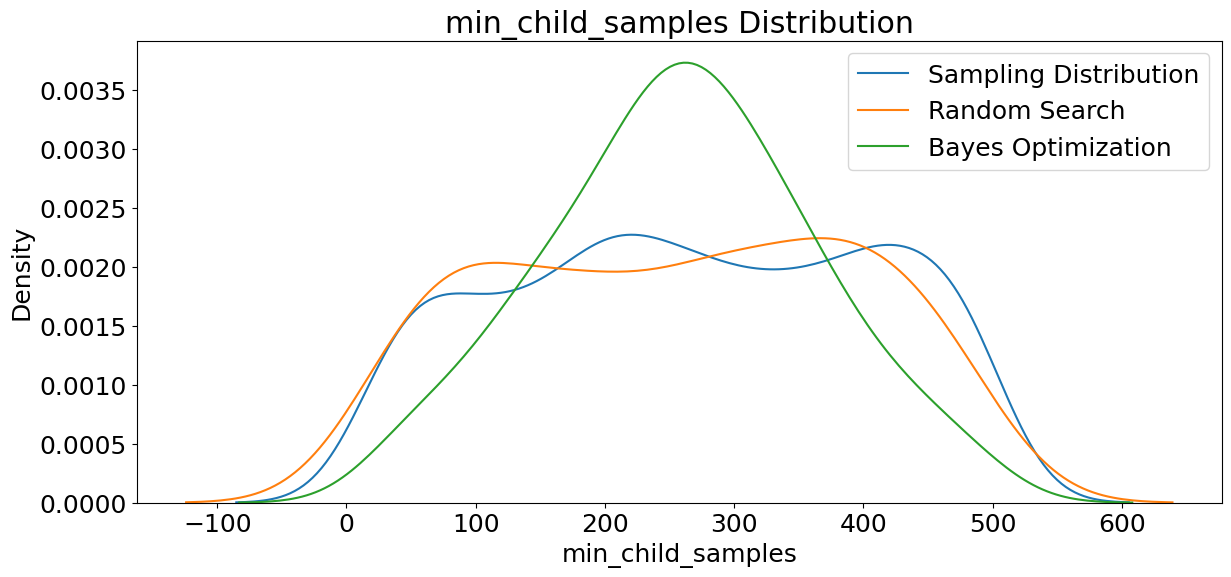

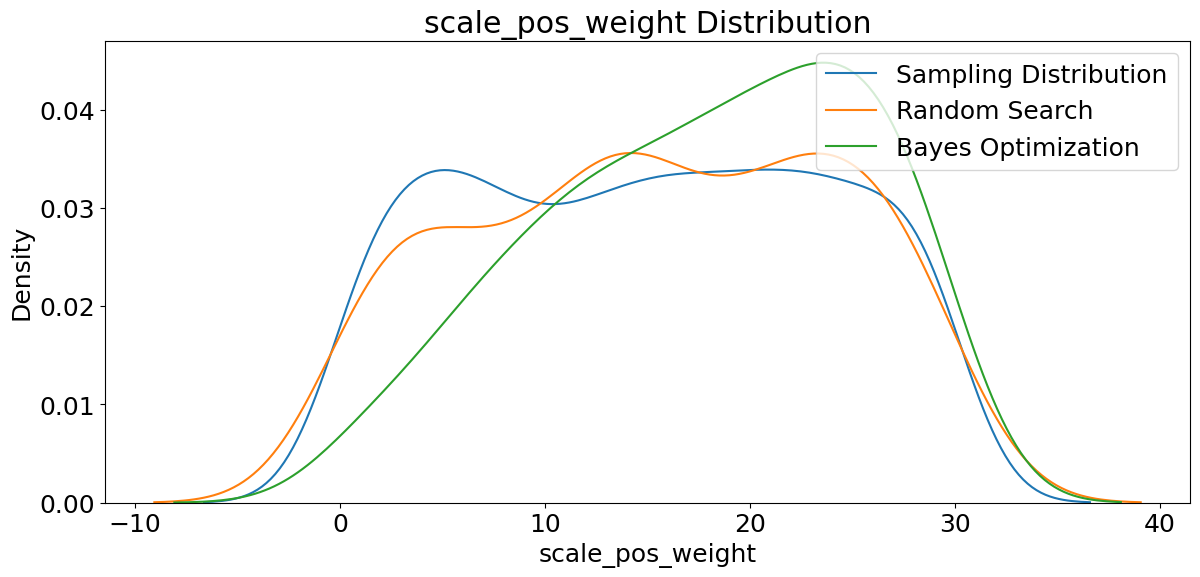

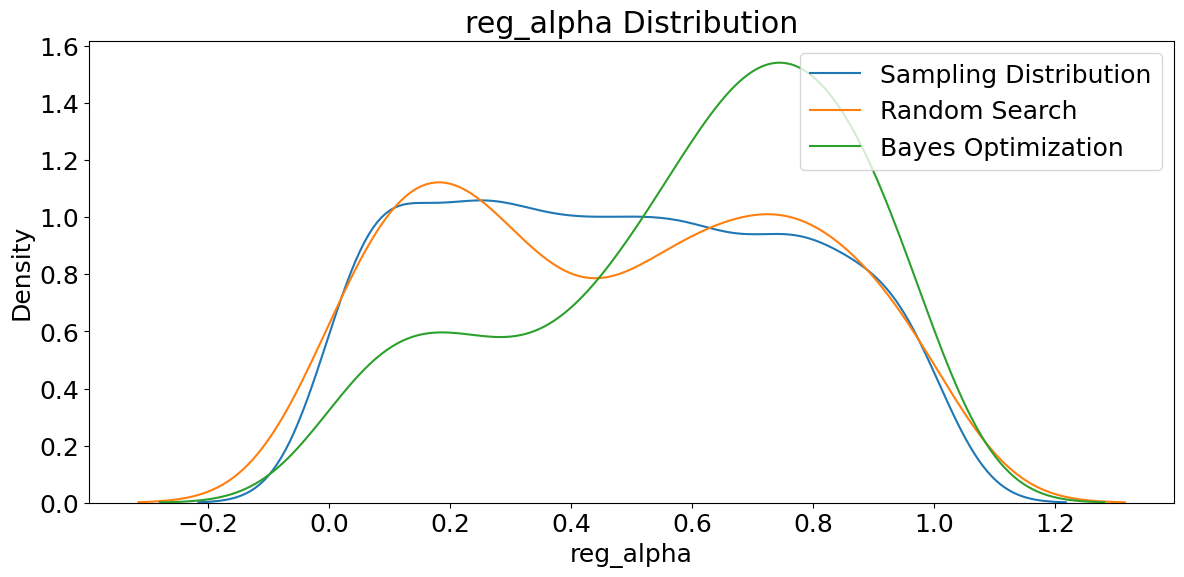

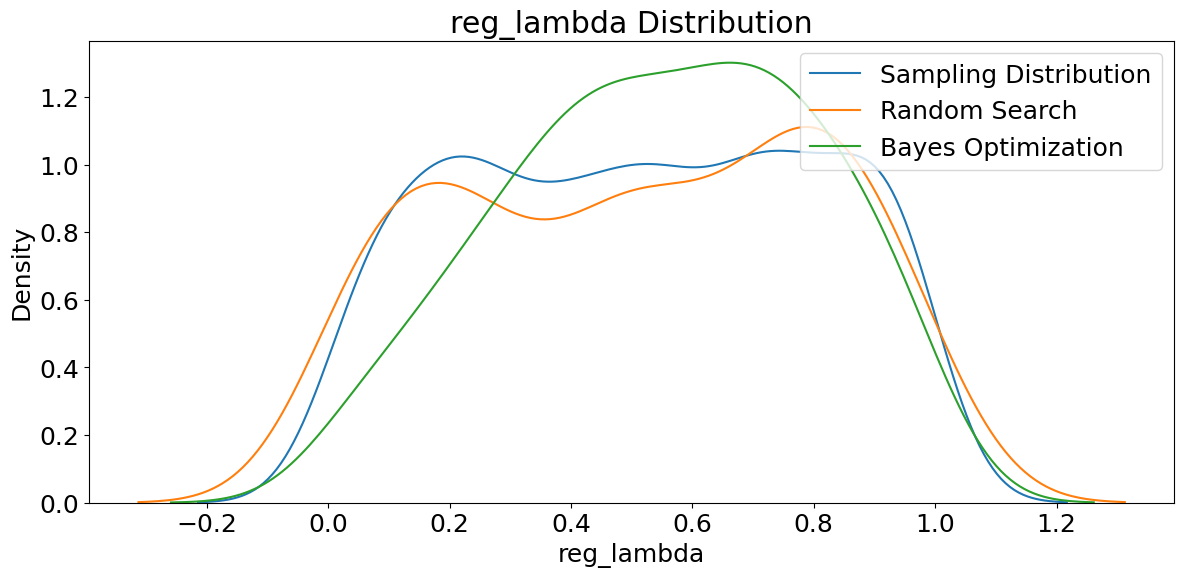

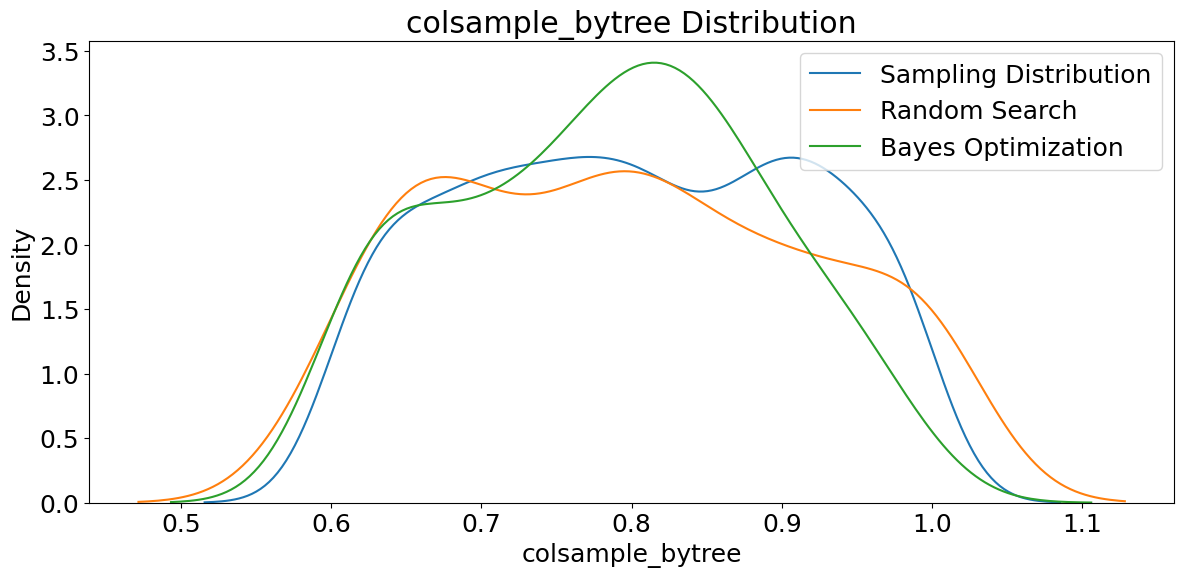

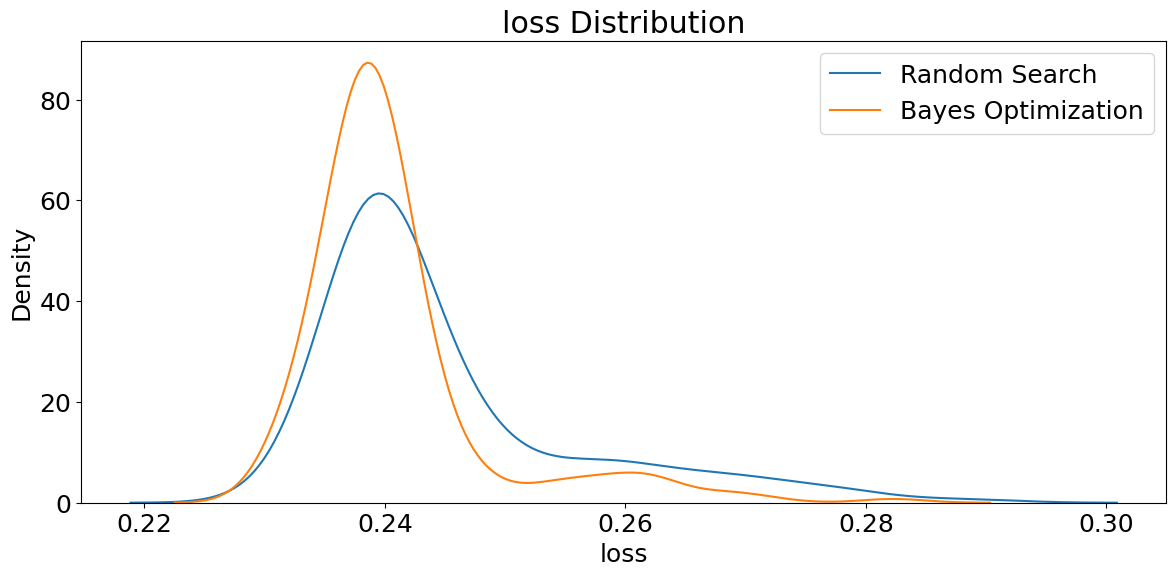

In [ ]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'is_unbalance', 'force_row_wise', 'verbose', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

Validation Losses

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})

scores_aux = pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'})
scores = pd.concat([scores,scores_aux])

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

,ROC AUC,iteration,search
0,0.769713,168,random
1,0.767795,4,random
2,0.767560,105,random
3,0.766820,144,random
4,0.766366,189,random


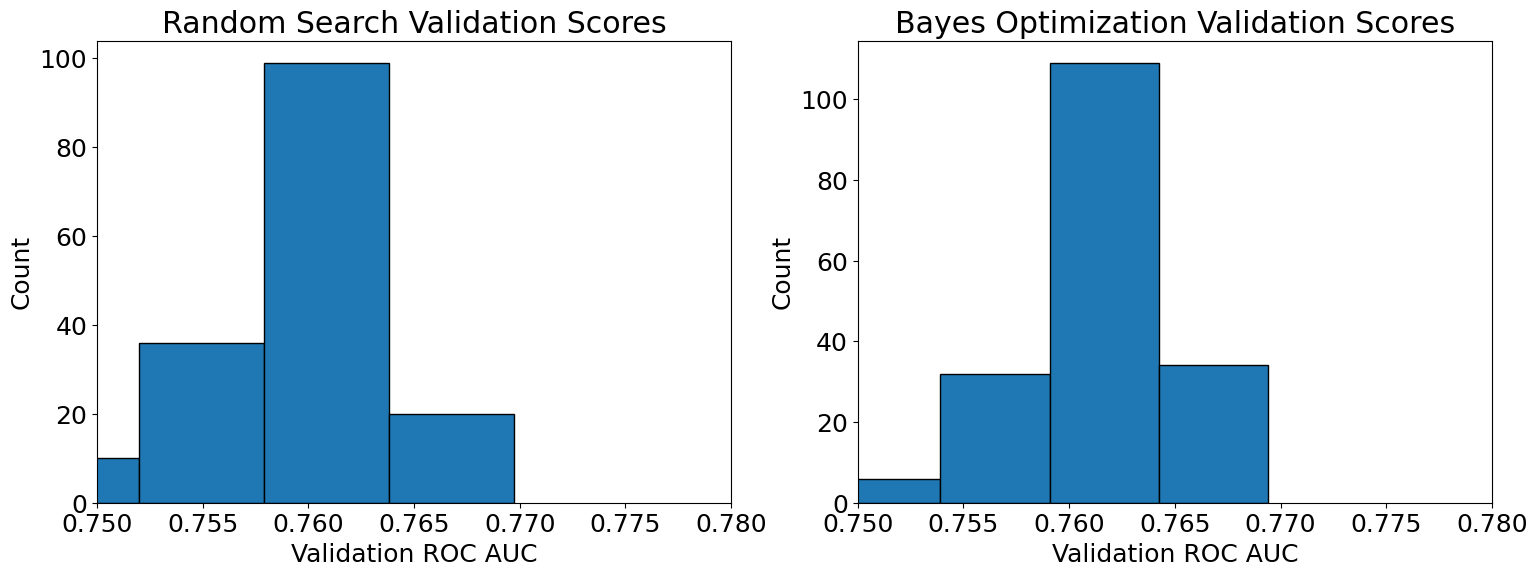

In [ ]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

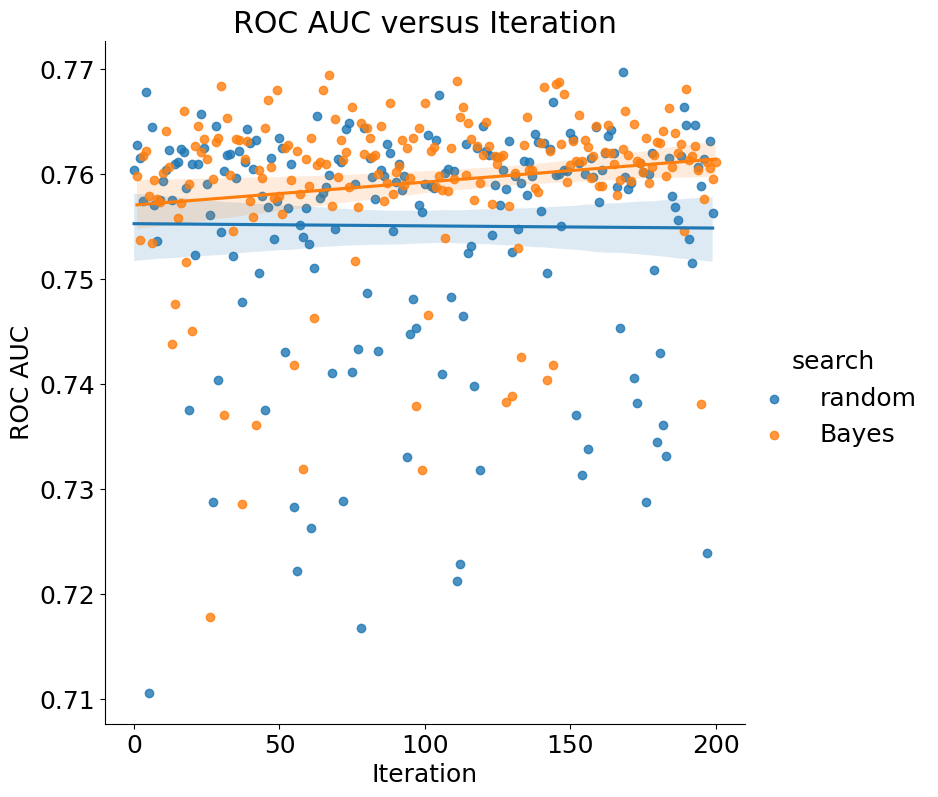

In [ ]:
# Plot of scores over the course of searching
sns.lmplot(x='iteration', y='ROC AUC', hue = 'search', data = scores, height = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");